<a href="https://colab.research.google.com/github/Ilvecho/Project_4/blob/main/P4_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle
import random
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Test and training data label assignment

If we have not done it yet, we unzip the images.zip file

In [ ]:
try:
  open('images/testing/flip/0001_000000020.jpg', 'rb')
except:
  !unzip /content/gdrive/MyDrive/images

Unfortunately colab does not have the os.listdir functionality (or at least I could not find it). So I created a dictionary with the list of file names and saved it in a pickle file on My Drive

In [40]:
import pickle

handle = open('/content/gdrive/MyDrive/img_names.pkl', 'rb')
img_names = pickle.load(handle)

check the image size and it's way too big, so we reduce the size and make sure that the action of flipping is still recognizable

(1920, 1080, 3)


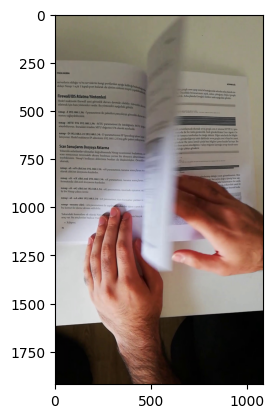

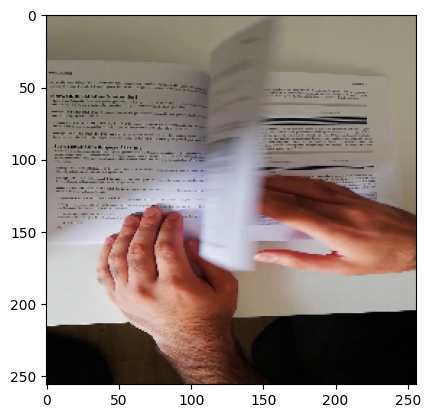

In [33]:
IMG_SIZE = 256

img_array = cv2.imread('images/testing/flip/0001_000000020.jpg')
print(img_array.shape)
img_cvt=cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
plt.imshow(img_cvt)
plt.show()

img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
img_cvt=cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
plt.imshow(img_cvt)
plt.show()

create a list of list with the resized img array and the corresponding label.
Then save the list in a pickle file.

We repeat the same steps for both training and testing

In [41]:
GCDIR = '/content/images'
CATEGORIES = ['flip', 'notflip']

cat_num = {'flip': 1, 'notflip': 0}

use = 'training'
data = []
label = []

for category in CATEGORIES:
  path = '/'.join([GCDIR,use,category])  # create path to the data

  # get the list of img names
  data_split_name = use + '_' + category
  names_list = img_names[data_split_name]

  for img in names_list:  # iterate over each image
    img_path = '/'.join([path, img])
    img_array = cv2.imread(img_path)  # convert to array
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY) # convert from BGR to GRAY
    img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) # reduce image size

    data.append(img_array)
    label.append(cat_num[category])


with open('/content/gdrive/MyDrive/training_img.pkl', 'wb') as handle:
  pickle.dump(data, handle)
with open('/content/gdrive/MyDrive/training_labels.pkl', 'wb') as handle:
  pickle.dump(label, handle)

In [42]:
use = 'testing'
data = []
label = []
for category in CATEGORIES:
  path = '/'.join([GCDIR,use,category])  # create path to the data

  # get the list of img names
  data_split_name = use + '_' + category
  names_list = img_names[data_split_name]

  for img in names_list:  # iterate over each image
    img_path = '/'.join([path, img])
    img_array = cv2.imread(img_path)  # convert to array
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY) # convert from BGR to GRAY
    img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))

    data.append(img_array)
    label.append(cat_num[category])


with open('/content/gdrive/MyDrive/test_img.pkl', 'wb') as handle:
  pickle.dump(data, handle)
with open('/content/gdrive/MyDrive/test_labels.pkl', 'wb') as handle:
  pickle.dump(label, handle)

# EDA

In [11]:
with open('/content/gdrive/MyDrive/training_data.pkl', 'rb') as handle:
  training_data = pickle.load(handle)

In [12]:
training_data = np.array(training_data, dtype=object)

In [87]:
training_data.shape
# first dimension contains the images, the second dimension contains the labels

(2392, 2)

In [88]:
train_set_balance = training_data[:, 1].sum() / training_data.shape[0]
print(train_set_balance)
# fairly balanced dataset

0.48578595317725753


The goal of the project is to detect whether or not there is flipping in a picture.

One of the caracteristics that will distinguish a picture with flipping will be the **blurring** of the moving parts.

Let's now use the FFT to compute the amount of blurring in each train image, to see if there is a distinction between flip and notflip

In [13]:
# Compute the center (x, y) coordinates to shift the FFT. Since we resize all the images, they all have the same size
IMG_SIZE = 256
(cX, cY) = (int(IMG_SIZE / 2.0), int(IMG_SIZE / 2.0))
size = 5

flip_mag = []
notflip_mag = []

for img, label in training_data:
  fft = np.fft.fft2(img)
  fftShift = np.fft.fftshift(fft)

  # remove the low frequencies from the FFT
  fftShift[cY - size:cY + size, cX - size:cX + size] = 0
  fftShift = np.fft.ifftshift(fftShift)
  recon = np.fft.ifft2(fftShift)

  # compute the magnitude of the modified FFT
  magnitude = 20 * np.log(np.abs(recon))
  mean = np.mean(magnitude)

  if label:
    flip_mag.append(mean)
  else:
    notflip_mag.append(mean)

In [14]:
flip_hist, flip_bins = np.histogram(flip_mag, bins=20)
notflip_hist, notflip_bins = np.histogram(notflip_mag, bins=20)
fig = go.Figure()
fig.add_trace(go.Bar(x=flip_bins[:-1], y=flip_hist, name='flip'))
fig.add_trace(go.Bar(x=notflip_bins[:-1], y=notflip_hist, name='notflip'))

fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.6)
fig.show()

We can observe that the not flip pictures tend to have a lower blur level with respect to the flip pictures.

Hopefully the model we are going to use will pick up this trend

# Model

We are going to use a Convolutional Neural Network to perform the classification task.

To implement the CNN, we are going to use PyTorch

In [5]:
from torch import nn
from torch import flatten

Some architecture details:
- The number of input channels is **one** as we are working with gray scale images
- We are going to use 3x3 kernels, because it's considered the optimal size
- Since we are using 3x3 kernels, we need to remember to add **padding** in order to avoid information loss. (however, we can also consider that the main focus of the task, in this case, should be in the center of the image, so the border pixels are not very informative)
- The main idea is to do convolution, followed by ReLU activations, followed by a max pooling to reduce the dimenionality and force the network to condense information. We start from images that are 256x256 (which is a power of 2), so we can do max pooling with kernel 2x2 and stride (2,2) to half the size of the output at each step
- after the convolution layers, we insert a couple of fully connected layers to perform the actual classification task (one with ReLU activations, and one with sigmoid for the output)

In [55]:
class CNN(nn.Module):

  def __init__(self):
    super(CNN,self).__init__()
    # initialize first set of CONV => RELU => POOL layers
    # input: 256x256x1  output: 256x256x10
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding='same')
    self.relu1 = nn.ReLU()
    # input: 256x256x10  output 128x128x10
    self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    # initialize second set of CONV => RELU => POOL layers
    # input: 128x128x10  output 128x128x20
    self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding='same')
    self.relu2 = nn.ReLU()
    # input: 128x128x20  output 64x64x20
    self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    # initialize third set of CONV => RELU => POOL layers
    # input: 64x64x20  output 64x64x30
    self.conv3 = nn.Conv2d(in_channels=20, out_channels=30, kernel_size=(3, 3), padding='same')
    self.relu3 = nn.ReLU()
    # input: 64x64x30  output 32x32x30
    self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    # initialize first (and only) set of FC => RELU layers
    self.fc1 = nn.Linear(in_features=30720, out_features=500)
    self.relu4 = nn.ReLU()

    # initialize the tanh classifier
    self.fc2 = nn.Linear(in_features=500, out_features=1)
    self.sigmoid = nn.Sigmoid()

  # forward pass function
  def forward(self, x):
    # pass the input through our first set of CONV => RELU => POOL layers
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.maxpool1(x)

    # pass the output from the previous layer through the second set of CONV => RELU => POOL layers
    x = self.conv2(x)
    x = self.relu2(x)
    x = self.maxpool2(x)

    # pass the output from the previous layer through the third set of CONV => RELU => POOL layers
    x = self.conv3(x)
    x = self.relu3(x)
    x = self.maxpool3(x)

    # flatten the output from the previous layer and pass it through the FC => RELU layer
    x = flatten(x, 1)
    x = self.fc1(x)
    x = self.relu4(x)

    # pass the output to the sigmoid function to get the output predictions
    x = self.fc2(x)
    output = self.sigmoid(x)
    # return the output predictions
    return output

Now that we created the network, let's train it

In [45]:
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
import argparse
import torch
import time

In [16]:
# define training hyperparameters
INIT_LR = 1e-3
BATCH_SIZE = 64
EPOCHS = 10

We might use Google Colab GPU/TPU if we notice that training is too long

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Load the data from the pickle files and then create the torch data loaders

In [69]:
with open('/content/gdrive/MyDrive/training_img.pkl', 'rb') as handle:
  training_X = pickle.load(handle)

with open('/content/gdrive/MyDrive/training_labels.pkl', 'rb') as handle:
  training_y = pickle.load(handle)

with open('/content/gdrive/MyDrive/test_img.pkl', 'rb') as handle:
  test_X = pickle.load(handle)

with open('/content/gdrive/MyDrive/test_labels.pkl', 'rb') as handle:
  test_y = pickle.load(handle)

In [65]:
training_y = [[y] for y in training_y]

In [70]:
# transform to torch tensor
training_X = torch.Tensor(training_X)
training_y = torch.Tensor(training_y)
test_X = torch.Tensor(test_X)
test_y = torch.Tensor(test_y)

# create the datasets as Torch likes them
train_dataset = TensorDataset(training_X, training_y)
test_dataset = TensorDataset(test_X, test_y)

train_data_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Initialize
- the model
- the loss function: it's a binary classification problem, so we are using the Binary Classification Error loss function
- the optimizer: we could use SGD (I know how it works), but we are going to use Adam, which is the best performing optimizer

In [73]:
model = CNN()
loss_fn = nn.BCELoss()
opt = Adam(model.parameters(), lr=INIT_LR)

In [85]:
# initialize a dictionary to store training history
H = {
	"train_loss": [],
	"train_acc": [],
	"test_loss": [],
	"test_acc": []
}

# calculate steps per epoch for training and validation set
train_steps = len(train_data_loader.dataset)
test_steps = len(test_data_loader.dataset)

Now we peform the actual training

In [87]:
# loop over our epochs
for e in range(0, EPOCHS):

  # set the model in training mode -> the computational graphs are saved to be used in backprop
  model.train()

  # initialize the total training and test loss -> it will be used to compute the average epoch values
  total_train_loss = 0
  total_test_loss = 0

  # initialize the number of correct predictions in the training and test step -> used to compute accuracy
  train_correct = 0
  test_correct = 0

  # loop over the training set
  for (x, y) in train_data_loader:
    # zero out the gradients
    opt.zero_grad()

    x = torch.reshape(x, (-1, 1, 256, 256))
    # perform a forward pass and calculate the training loss
    pred = model(x)
    pred = torch.reshape(pred, (-1,))
    loss = loss_fn(pred, y)

    # perform the backpropagation step, and update the weights

    loss.backward()
    opt.step()

    # add the loss to the total training loss so far and calculate the number of correct predictions
    total_train_loss += loss
    train_correct += (torch.round(pred) == y).type(torch.float).sum().item()
    break

  # switch off autograd for evaluation
  with torch.no_grad():

    # set the model in evaluation mode
    model.eval()

    for (x, y) in test_data_loader:

      x = torch.reshape(x, (-1, 1, 256, 256))

      # make the predictions and calculate the validation loss
      pred = model(x)
      pred = torch.reshape(pred, (-1,))
      total_test_loss += loss_fn(pred, y)
      # calculate the number of correct predictions
      test_correct += (torch.round(pred) == y).type(torch.float).sum().item()

  # calculate the average training and validation loss
  avg_train_loss = total_train_loss / train_steps
  avg_test_loss = total_test_loss / test_steps

  # calculate the training and validation accuracy
  train_correct = train_correct / train_steps
  test_correct = test_correct / test_steps

  # update our training history
  H["train_loss"].append(avg_train_loss)
  H["train_acc"].append(train_correct)
  H["test_loss"].append(avg_test_loss)
  H["test_acc"].append(test_correct)
  # print the model training and validation information
  print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
  print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avg_train_loss, train_correct))
  print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(avg_test_loss, test_correct))
  break

[INFO] EPOCH: 1/10
Train loss: 0.022209, Train accuracy: 0.0125
Val loss: 0.916039, Val accuracy: 0.4858

